# HW6. Decision Trees

1. Choose any dataset you want for binary classification with tabular data: https://www.kaggle.com/c/titanic

2. Make a basic EDA, write briefly a few conclusions that, in your opinion, will affect the model / model validation / metrics.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [59]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

train_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

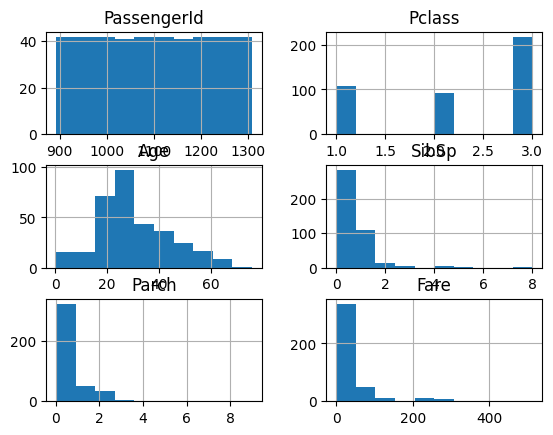

In [60]:
test_raw.hist()

In [61]:
train_raw_missing_values = train_raw.isnull().sum()
print(train_raw_missing_values[train_raw_missing_values > 0])

Age         177
Cabin       687
Embarked      2
dtype: int64


In [62]:
test_raw_missing_values = test_raw.isnull().sum()
print(test_raw_missing_values[test_raw_missing_values > 0])

Age       86
Fare       1
Cabin    327
dtype: int64


#### Missing values:
- Age: Let's use average value withing a given title and socio-economic status. E.g. Miss 3, 2, 1 have different avg ages.
- Cabin: I want to use Cabin to calculate number of people traveling together. But if cabin is missing, I plan to use number of people on the same ticket.
- Embarked: Only 2 values are missing, let's use most popular values to fill NaNs.
- Fare: Only 2 values are missing, let's use most popular values to fill NaNs.

In [91]:
def parse_name(data):
    data = data.copy()
    
    data[['surname', 'title', 'name_2']] = data['Name'].str.extract(r'([^,]*), ([^.]*)\. (.*)')
    data['second_name'] = data['Name'].str.extract(r'.*\((.*)\).*')
    data['second_surname'] = data['second_name'].str.extract(r'.* ([A-Za-z]*)')
    
    surname_values = data['surname'].value_counts()    
    surname_values_ext = pd.concat([data['surname'], data['second_surname']]).reset_index(drop=True).value_counts()    
    data['people_per_surname'] = data['surname'].map(surname_values)
    data['people_per_surname_ext'] = data['surname'].map(surname_values_ext) + data['second_surname'].map(surname_values_ext).fillna(0).astype(int)    
    
    return data.drop(columns=['second_name', 'second_surname', 'name_2'])


df = parse_name(train_raw)
x = df.groupby(['title', 'Pclass']).agg(
    avg_age=('Age', 'mean'),
    std_age=('Age', 'std'),
    count=('Age', 'size')
).reset_index()
x[x['count'] > 1]

,title,Pclass,avg_age,std_age,count
1,Col,1,58.000000,2.828427,2
3,Dr,1,43.750000,8.261356,5
4,Dr,2,38.500000,21.920310,2
7,Major,1,48.500000,4.949747,2
8,Master,1,5.306667,5.165475,3
9,Master,2,2.258889,2.342634,9
10,Master,3,5.350833,3.593608,28
11,Miss,1,30.000000,12.852308,46
12,Miss,2,22.390625,13.374708,34
13,Miss,3,16.123188,9.697315,102


array([[<Axes: title={'center': 'Age'}>]], dtype=object)

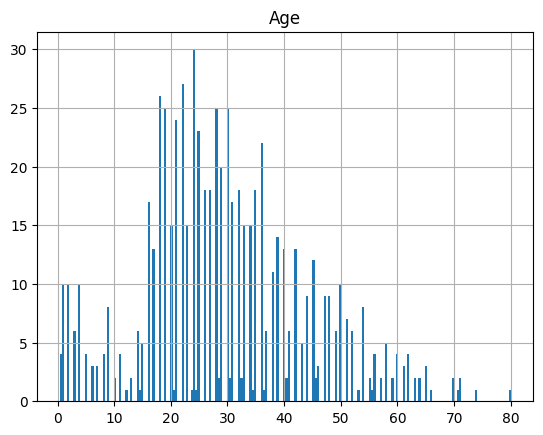

In [92]:
df.hist(column='Age', bins=200)

In [93]:
def count_people_per_ticket(data):    
    ticket_values = data['Ticket'].value_counts()
    data['people_per_ticket'] = data['Ticket'].map(ticket_values)

df = train_raw.copy()
count_people_per_ticket(df)
df['fare_per_person'] = df['Fare'] / df['people_per_ticket']
avg_fare = df.groupby('Pclass').agg(
    fare_per_person=('fare_per_person', 'mean'),
    std=('fare_per_person', 'std'),
    count=('fare_per_person', 'size')
).reset_index()
avg_fare

,Pclass,fare_per_person,std,count
0,1,43.650347,30.322236,216
1,2,13.322599,5.648278,184
2,3,8.085857,2.393923,491


High STD for first class suggestes that the missing data contains passangers booked on the same tickets (from train data).

So let's use [publicly available data](https://www.cruisemummy.co.uk/titanic-ticket-prices) about ticket prices:
- First class: 30
- Second class: 12
- Third class: 7

And calculate the number of people per ticket

In [96]:
pclass_fare = {
    1: 30,
    2: 12,
    3: 7
}

def enhance_features(data):    
    data = data.drop_duplicates(subset=['PassengerId']).set_index('PassengerId')
    data = parse_name(data)
    
    data['people_per_family'] = data['SibSp'] + data['Parch'] + 1
    
    top_embarked = data['Embarked'].value_counts().index[0]
    data['Embarked'] = data['Embarked'].fillna(top_embarked)
    
    avg_age = data.groupby(['title', 'Pclass'])['Age'].mean().reset_index()    
    data['Age'] = data.apply(lambda x: avg_age[(avg_age['title'] == x['title']) & (avg_age['Pclass'] == x['Pclass'])]['Age'].values[0] if np.isnan(x['Age']) else x['Age'], axis=1)    
    
    bin_edges = [0, 5, 10, 20, 30, 40, 50, 60, np.inf]
    data['age_bin'] = pd.cut(data['Age'], bins=bin_edges, right=False)
    
    data['fare_per_person'] = data['Pclass'].map(pclass_fare)
    data['people_per_ticket'] = (data['Fare'] / data['fare_per_person']).fillna(1).round().astype(int)
    
    cabin_values = data['Cabin'].value_counts()
    data['people_per_cabin'] = data['Cabin'].map(cabin_values).fillna(data['people_per_ticket']).astype(int) # If no data about cabin, get number of people per ticket
    
    # data[['cabin_letter', 'cabin_number']] = data['Cabin'].str.extract(r'([A-Za-z]*)(\d*)')
    # data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*')
    # data['ticket_number'] = data['Ticket'].str.extract(r'.* (\d*)')
    
    return data.drop(columns=['SibSp', 'Parch', 'Ticket', 'Cabin', 'Age', 'fare_per_person', 'Fare'])

train_X = enhance_features(train_raw.drop(columns=['Survived']))
train_y = train_raw['Survived']

train_X

,Pclass,Name,Sex,Embarked,surname,title,people_per_surname,people_per_surname_ext,people_per_family,age_bin,people_per_ticket,people_per_cabin
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,S,Braund,Mr,2,2,2,"[20.0, 30.0)",1,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,C,Cumings,Mrs,1,5,2,"[30.0, 40.0)",2,1
3,3,"Heikkinen, Miss. Laina",female,S,Heikkinen,Miss,1,1,1,"[20.0, 30.0)",1,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,S,Futrelle,Mrs,2,3,2,"[30.0, 40.0)",2,2
5,3,"Allen, Mr. William Henry",male,S,Allen,Mr,2,2,1,"[30.0, 40.0)",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,S,Montvila,Rev,1,1,1,"[20.0, 30.0)",1,1
888,1,"Graham, Miss. Margaret Edith",female,S,Graham,Miss,3,3,1,"[10.0, 20.0)",1,1
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,S,Johnston,Miss,2,2,4,"[10.0, 20.0)",3,3


In [97]:
# pip install ydata-profiling, ipywidgets

from ydata_profiling import ProfileReport
train_X_report = ProfileReport(train_X, explorative=True)
train_X_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
train_test = pd.concat([train_raw.drop(columns=['Survived']), test_raw.drop_duplicates()], axis=0)
train_test_X = enhance_features(train_test)
test_X = train_test_X.loc[test_raw.set_index('PassengerId').index]
test_X

,Pclass,Name,Sex,Embarked,surname,title,people_per_surname,people_per_surname_ext,people_per_family,age_bin,people_per_ticket,people_per_cabin
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,Q,Kelly,Mr,5,5,1,"[30.0, 40.0)",1,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,S,Wilkes,Mrs,1,3,2,"[40.0, 50.0)",1,1
894,2,"Myles, Mr. Thomas Francis",male,Q,Myles,Mr,1,1,1,"[60.0, inf)",1,1
895,3,"Wirz, Mr. Albert",male,S,Wirz,Mr,1,1,1,"[20.0, 30.0)",1,1
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,S,Hirvonen,Mrs,2,4,3,"[20.0, 30.0)",2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,S,Spector,Mr,1,1,1,"[20.0, 30.0)",1,1
1306,1,"Oliva y Ocana, Dona. Fermina",female,C,Oliva y Ocana,Dona,1,1,1,"[30.0, 40.0)",4,1
1307,3,"Saether, Mr. Simon Sivertsen",male,S,Saether,Mr,1,1,1,"[30.0, 40.0)",1,1


In [ ]:
from ydata_profiling import ProfileReport

test_X_report = ProfileReport(test_X, explorative=True)
test_X_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# make a research on the data and determine the best way to handle missing values

# implement the best way to handle missing values
# implement the best way to handle categorical values (encoding)

In [11]:
# define validation method
# use StratifiedKFold to split the data into folds or KFold if you don't need stratification

In [12]:
# define the regression model
# define the hyperparameters grid
# define the grid search with cross validation using previously defined validation method
# train the model
# print the best hyperparameters
# print the best score on train and validation data, estimate the generalization error

In [13]:
# define the decision tree model
# define the hyperparameters grid
# define the grid search with cross validation using previously defined validation method
# train the model
# print the best hyperparameters
# print the best score on train and validation data, estimate the generalization error

In [14]:
# compare the results of the two models
# make a conclusion on which model is better and why

In [15]:
# retrain the best models (both regression and DT) on the whole train data

In [16]:
# load test data
# do the same preprocessing as for train data

# using retrained models make predictions on the test data for both regression and DT models
# save the predictions to a file
# upload the predictions to Kaggle and make a submission
# report the score you got and compare it with the score you got on the validation data
# make a conclusion on how well the models generalizes